## Lab 3 (QMSS5016 Time Series, Panel Data & Forecasting)
**Submitted by**: Gideon Tay\
**My UNI**: gt2528\
**Contact me at**: gideon.tay@columbia.edu

I have two datasets:
- Google search volume for the word 'deals' in the United States from 2009-2019.
    - Data from [Google Trends](https://trends.google.com/trends/explore?date=2009-01-01%202019-12-01&geo=US&q=deals&hl=en-US)
- Month-on-month percentage changes in the Consumer Price Index for all urban consumers in the United States from 2009-2019. 
    - Data from [US Bureau of Labor Statistics](https://data.bls.gov/pdq/SurveyOutputServlet)

I would think that when people search for more deals, the month-on-month inflation decreases, as people look for special offers and discounts on items, possibly due to greater price sensitivity or yearly deal seasons, firms lower prices in response, and average prices fall.

I have already merged the two datasets together beforehand. Let's start by importing required libraries and loading in the data:

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import kpss
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Read in the uploaded file and display first few rows
data = pd.read_csv("Merged_Deals_and_Inflation_Data.csv")
data.head()

,Month,MoMInflation,DealsSearchVolume
0,2009-01,0.3,24
1,2009-02,0.4,23
2,2009-03,0.4,23
3,2009-04,0.2,20
4,2009-05,0.0,22


### 1. Create a multivariate time series; perform any interpolations.

Let's first check if there are any missing values in this dataframe:

In [3]:
# Check if there are any missing values
has_missing = data.isnull().values.any()
print("Any missing values:", has_missing)

Any missing values: False


Since there are no missing values, we do not need to perform any interpolation of data.

Let's create dummies for each month to possibly capture seasonal effects:

In [4]:
# Convert 'Month' to a datetime object and set as index
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Create monthly dummies
data['Month_Num'] = data.index.month
monthly_dummies = pd.get_dummies(
    data['Month_Num'], prefix='Month', drop_first=True
)
data = pd.concat([data, monthly_dummies], axis=1)

# Display first 13 rows of dataframe
data.head(13)

,MoMInflation,DealsSearchVolume,Month_Num,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Month,,,,,,,,,,,,,,
2009-01-01,0.3,24,1,False,False,False,False,False,False,False,False,False,False,False
2009-02-01,0.4,23,2,True,False,False,False,False,False,False,False,False,False,False
2009-03-01,0.4,23,3,False,True,False,False,False,False,False,False,False,False,False
2009-04-01,0.2,20,4,False,False,True,False,False,False,False,False,False,False,False
2009-05-01,0.0,22,5,False,False,False,True,False,False,False,False,False,False,False
2009-06-01,0.1,24,6,False,False,False,False,True,False,False,False,False,False,False
2009-07-01,0.0,26,7,False,False,False,False,False,True,False,False,False,False,False
2009-08-01,0.1,23,8,False,False,False,False,False,False,True,False,False,False,False
2009-09-01,0.2,19,9,False,False,False,False,False,False,False,True,False,False,False


### 2. Graph the relationships between X and Y. Explain how you think Y should relate to your key Xs.

Let's visualize the relationship between month-on-month inflation and search volume for 'deals' over time. Note that since they have different scales, it is hard to plot them on the same y-axis. To visualize them better, I use 2 separate y-axis for each variable:

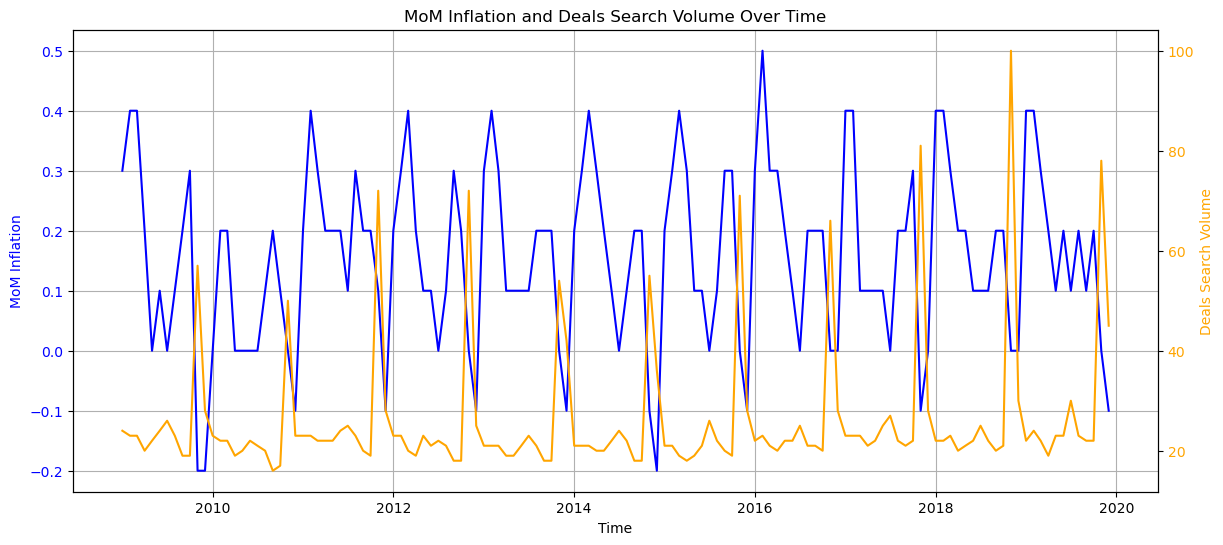

In [5]:
# Plot 'MoMInflation' on the left y-axis
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(data.index, data['MoMInflation'], label='MoM Inflation', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('MoM Inflation', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for 'DealsSearchVolume'
ax2 = ax1.twinx()  # Create a twin Axes sharing the x-axis
ax2.plot(data.index, data['DealsSearchVolume'], label='Deals Search Volume', color='orange')
ax2.set_ylabel('Deals Search Volume', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add title and grid
plt.title('MoM Inflation and Deals Search Volume Over Time')
ax1.grid(True)

This provides an intuitive understanding of how these variables vary together. The graphs reveal a seasonal pattern in both month-on-month inflation and 'deals' search volume, suggesting a potential correlation that warrants further exploration.

- In particular, we see that months with high 'deals' search volume (orange peaks) coincide with months with low MoM inflation (blue troughs).
- Each year, there appears to be a second shallower blue trough between a tall and short blue spike. This shallower blue trough which roughly corresponds to a smaller orange peak as well.

Visually, we thus observe some form of negative relation between the two variables as expected. I would think that when people search for more deals, the month-on-month inflation decreases, as people look for special offers and discounts on items, possibly due to greater price sensitivity or yearly deal seasons, firms lower prices in response, and average prices fall.

The large spike in deal search seems to occur near the year end during the Christmas period and this corresponds to a large drop in month-on-month inflation from November to December.

Let's plot a scatter plot too:

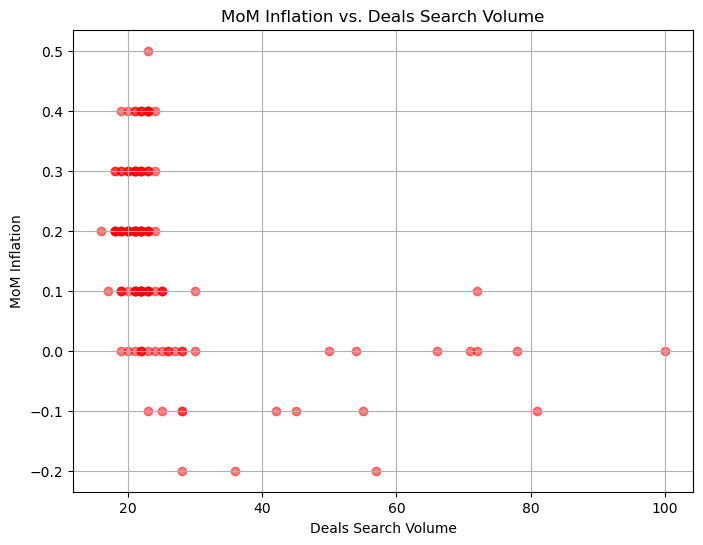

In [6]:
# Plot a scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(
    data['DealsSearchVolume'], 
    data['MoMInflation'],
    color='red', alpha=0.5
    )
plt.title('MoM Inflation vs. Deals Search Volume')
plt.ylabel('MoM Inflation')
plt.xlabel('Deals Search Volume')
plt.grid(True)
plt.show()

The relation between the two variables is rather unclear, but there appears to be a very rough negative relation.

### 3. Run a simple time series regression, with one X and no trend. Interpret it.

We will run a "naive" model predicting search as a function of MoM inflation:

In [7]:
# Regression with Only Deal Search Volume Predicting MoM Inflation
model_search_only = ols('MoMInflation ~ DealsSearchVolume', data=data).fit()
print(model_search_only.summary())

                            OLS Regression Results                            
Dep. Variable:           MoMInflation   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     32.94
Date:                Sat, 07 Dec 2024   Prob (F-statistic):           6.37e-08
Time:                        01:05:13   Log-Likelihood:                 79.433
No. Observations:                 132   AIC:                            -154.9
Df Residuals:                     130   BIC:                            -149.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2799      0.02

**Interpretation**: we see that the results show a significant negative relationship, with 'deals' search volume explaining about 20% of the variability in MoM Inflation.

### 4. Run a time series regression with one X and trend. Interpret it. Perform autocorrelation diagnostics. Explain what you found.

We know that usually, it is too simple to just correlate two time series variables together, so we must do more.  Adding a trend and monthly dummies in the fourth step accounts for time effects and seasonality, providing a more nuanced model. This allows us to distill their relationship beyond broader temporal patterns.

In [8]:
# Create a trend variable
data['Trend'] = np.arange(1, len(data) + 1)

# OLS regression with trend and monthly dummies
model_with_trend = ols(
    'MoMInflation ~ DealsSearchVolume + Trend + ' + 
    ' + '.join(monthly_dummies.columns),
    data=data
).fit()
print(model_with_trend.summary())

                            OLS Regression Results                            
Dep. Variable:           MoMInflation   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     30.11
Date:                Sat, 07 Dec 2024   Prob (F-statistic):           2.06e-31
Time:                        01:05:13   Log-Likelihood:                 161.06
No. Observations:                 132   AIC:                            -294.1
Df Residuals:                     118   BIC:                            -253.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2411      0.03

**Interpretation**: 
- The findings indicate that both trend and certain months significantly affect search volume, suggesting seasonality and gradual positive trend of higher MoM inflation over time (very small positive coefficient on Trend). 
- Large negative coefficient on Month_12, suggesting that MoM inflation is low in December. This is statistically significant (p-value<0.01). This could be due to Christmas holiday discounts. 
- However, after controlling for seasonality and trend, DealsSearchVolume is no longer statistically significant (p-value>0.1).
- This suggests that 'deals' search volume is only related to MoM inflation to the extent that people search for deals during specific seasons (e.g. Christmas) and firms lower prices during those seasons. 
- It possibly suggests that people do not really search for 'deals' for other reasons such as increased price sensitivity unrelated to seasons, so firms do not reduce prices and MoM inflation is not lower when people search for 'deals' outside typical seasons.

**Autocorrelation diagnostics**: The Durbin-Watson statistic is less than and still pretty far away from 2.0, suggesting maybe still some positive autocorrelation in MoM inflation (DW < 2 suggests negative autocorrelation).

### 5. Consider running a time series regression with many Xs and trend. Interpret that. Check VIF.

To address multicollinearity, we calculate the Variance Inflation Factor (VIF) for the predictors. This ensures that our regression estimates are not distorted by highly correlated variables.

In [9]:
# Select the predictors (X variables) from the data
predictors = data.drop(columns=['MoMInflation']) # Drop y variable MoMInflation

# Ensure predictors are numeric and contain no missing values
predictors_cleaned = predictors.select_dtypes(include=[np.number]).dropna()

# Recalculate VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = predictors_cleaned.columns
vif_data['VIF'] = [
    variance_inflation_factor(predictors_cleaned.values, i) 
    for i in range(predictors_cleaned.shape[1])
]

# Display the VIF results
print(vif_data)


            Variable       VIF
0  DealsSearchVolume  4.928433
1          Month_Num  4.704739
2              Trend  3.039500


The analysis reveals moderate multicollinearity for DealsSearchVolume, Month_Num, and Trend. 
- VIF = 1: indicates no multicollinearity, the variable is not correlated with other predictors in the model. 
- VIF between 1 and 5: Moderate level of correlation, usually considered acceptable. 

Although there is some multicollinearity, they are still within an acceptable range as VIF < 5.

### 6. Run a first differenced time series regression. Interpret that.

We perform a first-differenced regression with "change in month" dummies to focus on short-term changes and seasonal transitions. This step removes trends and isolates month-to-month shifts in MoM inflation.

In [10]:
# Updated First-Differenced Model with "Change in Month" Dummies
data['Diff_MoMInflation'] = data['MoMInflation'].diff()
data['Diff_DealsSearchVolume'] = data['DealsSearchVolume'].diff()
change_in_month_dummies = monthly_dummies.diff().iloc[1:]
data_with_differences = pd.concat(
    [data[['Diff_MoMInflation', 'Diff_DealsSearchVolume']], 
     change_in_month_dummies], axis=1
).dropna()
model_diff_with_change_dummies = ols(
    'Diff_MoMInflation ~ Diff_DealsSearchVolume + ' +
    ' + '.join(change_in_month_dummies.columns),
    data=data_with_differences
).fit()
print(model_diff_with_change_dummies.summary())

                            OLS Regression Results                            
Dep. Variable:      Diff_MoMInflation   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     31.90
Date:                Sat, 07 Dec 2024   Prob (F-statistic):           2.01e-30
Time:                        01:05:13   Log-Likelihood:                 143.27
No. Observations:                 131   AIC:                            -262.5
Df Residuals:                     119   BIC:                            -228.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

**Interpretation**: 

- Changes in 'deals' search volume between months is not significantly associated with changes in MoM inflation between months (p-value>0.1).
- Durbin-Watson statistic is now above 2, by quite a bit. Differencing seems to have resolved our initial positive autocorrelation issue, where DW statistic was far below 2. However, now we may have negative autocorrelation.

### 7. Check your variables for unit roots. Do some tests. Interpret them.

Apply the KPSS test to assess the stationarity of the original and differenced series for both the MoM inflation and 'Deals' Search Volume variables:

In [11]:
# Define KPSS Test for Stationarity
def kpss_test(series):
    statistic, p_value, _, critical_values = kpss(series, regression='c')
    return {
        'KPSS Statistic': statistic, 
        'p-value': p_value, 
        'Critical Values': critical_values
    }

# KPSS Test for DealsSearchVolume and MoM Inflation
kpss_original = kpss_test(data['DealsSearchVolume'].dropna())
kpss_diff = kpss_test(data['Diff_DealsSearchVolume'].dropna())
kpss_original2 = kpss_test(data['MoMInflation'].dropna())
kpss_diff2 = kpss_test(data['Diff_MoMInflation'].dropna())

# Print results
print("KPSS Test Results (Original DealsSearchVolume):", kpss_original)
print("KPSS Test Results (Differenced DealsSearchVolume):", kpss_diff)
print("")
print("KPSS Test Results (Original MoMInflation):", kpss_original2)
print("KPSS Test Results (Differenced MoMInflation):", kpss_diff2)

KPSS Test Results (Original DealsSearchVolume): {'KPSS Statistic': 0.2840442934866382, 'p-value': 0.1, 'Critical Values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}}
KPSS Test Results (Differenced DealsSearchVolume): {'KPSS Statistic': 0.3989788317817938, 'p-value': 0.07759533112853717, 'Critical Values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}}

KPSS Test Results (Original MoMInflation): {'KPSS Statistic': 0.09322859578614048, 'p-value': 0.1, 'Critical Values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}}
KPSS Test Results (Differenced MoMInflation): {'KPSS Statistic': 0.14136748274434152, 'p-value': 0.1, 'Critical Values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}}


C:\Users\gideo\AppData\Local\Temp\ipykernel_10424\1126586665.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, _, critical_values = kpss(series, regression='c')
C:\Users\gideo\AppData\Local\Temp\ipykernel_10424\1126586665.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, _, critical_values = kpss(series, regression='c')
C:\Users\gideo\AppData\Local\Temp\ipykernel_10424\1126586665.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, _, critical_values = kpss(series, regression='c')


The test confirms that the original series for both variables are already stationarity (p>.05), and we fail to reject the null of stationarity. We still fail to reject the null of stationarity after differencing.

We thus do not have a unit root problem.

### 8. Perform an Automatic ARIMA on the residuals from one of your earlier models. Tell me what it says.

The `auto_arima` function automatically finds the best ARIMA model based on the residuals. It tries different combinations of AR, I, MA, and seasonal parameters and uses AIC/BIC to select the best model. I will perform an automatic ARIMA on the residuals of my OLS model with trend and monthly dummies:

In [12]:
# Fit the OLS model
model_with_trend = ols(
    'MoMInflation ~ DealsSearchVolume + Trend + ' + 
    ' + '.join(monthly_dummies.columns),
    data=data
).fit()

# Extract the residuals
residuals = model_with_trend.resid

# Automatically fit an ARIMA model to the residuals
arima_model = auto_arima(residuals, seasonal=False, stepwise=True, trace=True)

# Print the summary of the ARIMA model
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-330.085, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-320.115, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-335.836, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-333.827, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-333.836, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-333.836, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-331.836, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-333.836, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.782 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 169.918
Date:                Sat, 07 Dec 2024   AIC                           -335.836
Time:                        01:05:1

**Interpretation**:

- ARIMA(1,0,0) is the best model with the lowest AIC (-335.836). Other models have higher AIC values. AIC balances model complexity and goodness of fit.
- ARIMA(1,0,0) consists of:
    - 1 autoregressive term (AR(1)): Indicates that the current value depends on one lagged value.
    - 0 differencing (d=0): Data was stationary, so no differencing was needed.
    - 0 moving average terms (MA(0)): No short-term shocks needed.
- This indicates that the residuals primarily depend on the first lag, without other time-dependent structures.
- ar.L1 (0.3548) is the coefficient of the first lag (AR(1)). It quantifies the dependency of residuals on their immediate past values.
    - A positive value of 0.3548 means that residuals tend to continue in the same direction as the previous period, but with diminishing strength.
    - The p-value (< 0.001) indicates this relationship is statistically significant.
- Ljung-Box Test (Q): p-value = 1.00
    - Tests for autocorrelation in residuals. A p-value = 1.00 suggests no significant autocorrelation remains, meaning the ARIMA model has successfully captured the time-dependent structure.
- Heteroskedasticity (H): p-value = 0.30
    - Tests for constant variance in residuals. A p-value = 0.30 suggests no significant heteroskedasticity.

### 9. Run an ARIMA that follows from Step 8. Interpret that, too.

From Step 8, we found the residuals to have no significant autocorrelation or heteroskedasticity. Hence, we can run an ARIMA model directly on the dependent variable `MoMInflation`. Step 8 showed ARIMA(1,0,0) model was the best fit for residuals in our OLS model of `MoMInflation` against trend and month dummies. 

Hence, we shall fix non-seasonal AR, differencing, and MA to (p=1, d=0, q=0) respectively. We also know there are 12 months, so we shall fix seasonal period length to m=12. We fix seasonal order to P=D=Q=1 as well for now and observe if they are significant:

In [13]:
# Fit SARIMAX with 12 seasonal periods (seasonal_order=(1, 1, 1, 12))
sarimax_model = ARIMA(
    data['MoMInflation'],
    order=(1, 0, 0),  # non-seasonal ARIMA order from Step 8
    seasonal_order=(1, 1, 1, 12)  # SARIMA seasonal order (P, D, Q, m)
).fit()

# Display the summary
print(sarimax_model.summary())

C:\Users\gideo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gideo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\gideo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                       MoMInflation   No. Observations:                  132
Model:             ARIMA(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                 133.501
Date:                            Sat, 07 Dec 2024   AIC                           -259.003
Time:                                    01:05:15   BIC                           -247.853
Sample:                                01-01-2009   HQIC                          -254.474
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3912      0.086      4.569      0.000       0.223       0.559
ar.S.L12      -0.0037      0.149   

**Interpretation**:
- Non-seasonal AR(1) coefficient (0.3912):
    - The coefficient for the first-order autoregressive term is 0.3912, which indicates moderate positive autocorrelation at lag 1. The p-value of 0.000 suggests this parameter is statistically significant.
- Seasonal AR(1) coefficient (-0.0037):
    - The seasonal autoregressive term at lag 12 is close to zero, with a p-value of 0.980, indicating it is not statistically significant and likely doesn't contribute much to the model.
- Seasonal AR(1) coefficient (-0.0037): 
    - The seasonal autoregressive term at lag 12 is close to zero, with a p-value of 0.980, indicating it is not statistically significant and likely doesn't contribute much to the model.
- Seasonal MA(1) coefficient (-0.7747): 
    - The seasonal moving average term at lag 12 is negative, with a statistically significant p-value of 0.000. This suggests that seasonal shocks have a significant negative impact on the model.
    - This makes sense, based on the visual representation of the data where we observe seasonal spikes in MoMInflation during months like December rather than a gradual decaying increase, which would suggest seasonal AR(1) instead.
 
**Model Diagnostics**:

- Ljung-Box (Q): The Ljung-Box test statistic is 0.53, with a p-value of 0.47. This suggests that there is no significant autocorrelation remaining in the residuals (i.e., the model has captured all significant dependencies).
- Heteroskedasticity (H): The test statistic is 0.75, with a p-value of 0.38, indicating that the residuals do not show significant heteroskedasticity (i.e., variance does not change over time).